# Hurst Exponent for trends confirmation

#### Basic of the Hurst Exponent
The Hurst Exponent, denoted as H, is a statistical measure that gives us a window into the behavior of time series data. Whether it’s the price of a stock, the flow rate of a river, or even internet traffic, H seeks to determine the nature of its behavior. Put simply, the interpretation of the Hurst Exponent is as follows

- If H=0.5, the process is akin to a random walk, like the flipping of a coin.
- If H<0.5, it suggests a series that tends to mean-revert. In the context of stocks, this might hint at an oscillatory behavior where if the stock price rises, it’s likely to fall back to its mean and vice-versa.
- If H>0.5, it indicates a trending series. This would mean that if a stock price rises, it’s likely to continue on that upward trajectory.

In [10]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [36]:
def calculate_hurst_exponent(stock_ticker):
    # Get the stock data from Yahoo Finance
    stock = yf.Ticker(stock_ticker)
    data = stock.history(period="max")
    # Extract the closing prices
    close_prices = data["Close"].values
# Calculate the log returns of the closing prices
    log_returns = np.log(close_prices[1:] / close_prices[:-1])
# Initialize the range of scales to consider
    scales = range(10, len(log_returns) + 1, 10)
# Initialize an empty list to store the Hurst exponents
    hurst_exponents = []
    # Calculate the Hurst exponent for each scale
    for scale in scales:
        # Calculate the cumulative sum of the log returns
        cumulative_sum = np.cumsum(log_returns[:scale])

        # Calculate the range of the cumulative sum
        R = np.max(cumulative_sum) - np.min(cumulative_sum)

        # Calculate the standard deviation of the log returns
        std = np.std(log_returns[:scale])

        # Calculate the Hurst exponent for this scale
        H = R / (std * scale ** 0.5)

        # Add the Hurst exponent to the list
        hurst_exponents.append(H)
    # Calculate the mean Hurst exponent over all scales
    hurst_exponent = np.mean(hurst_exponents)

    return hurst_exponent

In [37]:
# Calculate the Hurst exponents for two stocks
stock_1_hurst_exponent = calculate_hurst_exponent("SBIN.NS")
stock_2_hurst_exponent = calculate_hurst_exponent("HSCL.NS")

print("Stock 1 Hurst Exponent:", stock_1_hurst_exponent)
print("Stock 2 Hurst Exponent:", stock_2_hurst_exponent)

Stock 1 Hurst Exponent: 1.6831989959306028
Stock 2 Hurst Exponent: 1.7424157655634913


Stock 2 is more likely to exhibit long-term trends than Stock 1.


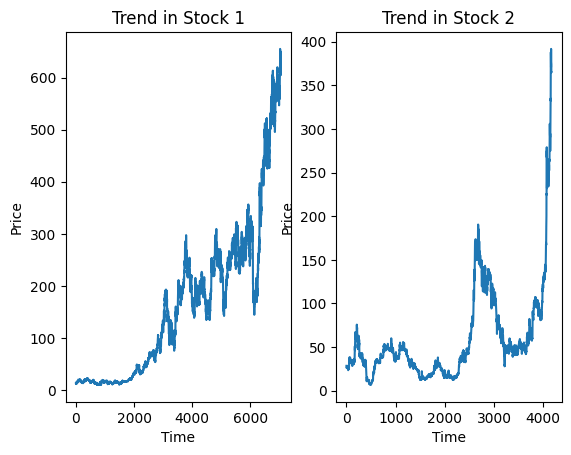

In [38]:
# Check if both Hurst exponents are not None before comparison
if stock_1_hurst_exponent is not None and stock_2_hurst_exponent is not None:
    # Compare the Hurst exponents of the two stocks
    if stock_1_hurst_exponent > stock_2_hurst_exponent:
        print("Stock 1 is more likely to exhibit long-term trends than Stock 2.")
    elif stock_1_hurst_exponent < stock_2_hurst_exponent:
        print("Stock 2 is more likely to exhibit long-term trends than Stock 1.")
    else:
        print("Stock 1 and Stock 2 are equally likely to exhibit long-term trends.")
else:
    print("One or both of the Hurst exponents is None. Cannot compare.")


# Plot the trends of the two stocks side by side
fig, ax = plt.subplots(1, 2)

# Plot the trend for Stock 1
ax[0].plot(yf.Ticker("SBIN.NS").history(period="max")["Close"].values)
ax[0].set_title("Trend in Stock 1")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Price")

# Plot the trend for Stock 2
ax[1].plot(yf.Ticker("HSCL.NS").history(period="max")["Close"].values)
ax[1].set_title("Trend in Stock 2")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Price")

plt.show()

### Rolling Hurst Exponent

In [40]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

symbol = "RVNL.NS"
start_date = "2018-01-01"
end_date = "2023-12-31"
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [41]:
def hurst_fd(price_series, min_window=10, max_window=100, num_windows=20, num_samples=100):
    log_returns = np.diff(np.log(price_series))
    window_sizes = np.linspace(min_window, max_window, num_windows, dtype=int)
    R_S = []

    for w in window_sizes:
        R, S = [], []
        for _ in range(num_samples):
            start = np.random.randint(0, len(log_returns) - w)
            seq = log_returns[start:start + w]
            R.append(np.max(seq) - np.min(seq))
            S.append(np.std(seq))

        R_S.append(np.mean(R) / np.mean(S))

    log_window_sizes = np.log(window_sizes)
    log_R_S = np.log(R_S)
    coeffs = np.polyfit(log_window_sizes, log_R_S, 1)
    hurst_exponent = coeffs[0]
    fractal_dimension = 2 - hurst_exponent

    return hurst_exponent, fractal_dimension

def rolling_hurst(price_series, window, min_window=10, max_window=100, num_windows=20, num_samples=100):
    return price_series.rolling(window=window).apply(lambda x: hurst_fd(x, min_window, max_window, num_windows, num_samples)[0], raw=True)

def rolling_fractal_dimension(price_series, window, min_window=10, max_window=100, num_windows=20, num_samples=100):
    return price_series.rolling(window=window).apply(lambda x: hurst_fd(x, min_window, max_window, num_windows, num_samples)[1], raw=True)

In [46]:
# Essential Libraries Import
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Function to calculate Hurst Exponent and Fractal Dimension
def hurst_fd(price_series, min_window=10, max_window=100, num_windows=20, num_samples=100):
    # Calculate logarithmic returns
    log_returns = np.diff(np.log(price_series))
    
    # Define window sizes for the resampling approach
    window_sizes = np.linspace(min_window, max_window, num_windows, dtype=int)
    R_S = []

    # For each window size, calculate R/S values
    for w in window_sizes:
        R, S = [], []
        
        # Resample multiple sequences for a more robust estimate
        for _ in range(num_samples):
            start = np.random.randint(0, len(log_returns) - w)
            seq = log_returns[start:start + w]
            R.append(np.max(seq) - np.min(seq))
            S.append(np.std(seq))

        R_S.append(np.mean(R) / np.mean(S))

    # Calculate the slope (Hurst Exponent) in a log-log plot
    log_window_sizes = np.log(window_sizes)
    log_R_S = np.log(R_S)
    coeffs = np.polyfit(log_window_sizes, log_R_S, 1)

    # Extract Hurst Exponent and derive Fractal Dimension
    hurst_exponent = coeffs[0]
    fractal_dimension = 2 - hurst_exponent

    return hurst_exponent, fractal_dimension

# Function to calculate rolling Hurst Exponent
def rolling_hurst(price_series, window, min_window=10, max_window=100, num_windows=20, num_samples=100):
    return price_series.rolling(window=window).apply(lambda x: hurst_fd(x, min_window, max_window, num_windows, num_samples)[0], raw=True)

# Function to calculate rolling Fractal Dimension
def rolling_fractal_dimension(price_series, window, min_window=10, max_window=100, num_windows=20, num_samples=100):
    return price_series.rolling(window=window).apply(lambda x: hurst_fd(x, min_window, max_window, num_windows, num_samples)[1], raw=True)

# Define symbol and fetch its historical data
symbol = "IRFC.NS"
start_date = "2018-01-01"
end_date = "2024-12-27"
df = yf.download(symbol, start=start_date, end=end_date)

# Calculate rolling Hurst Exponent and Fractal Dimension for the stock data
rolling_window = 120
df['hurst_exponent'] = rolling_hurst(df['Close'], rolling_window)
df['fractal_dimension'] = rolling_fractal_dimension(df['Close'], rolling_window)
df.dropna(inplace=True)

# Calculate 30-day Simple Moving Average for visualization purposes
sma_window = 30
df['sma'] = df['Close'].rolling(window=sma_window).mean()

# Calculate mean price for visualization purposes
mean_price = df['Close'].mean()


[*********************100%%**********************]  1 of 1 completed


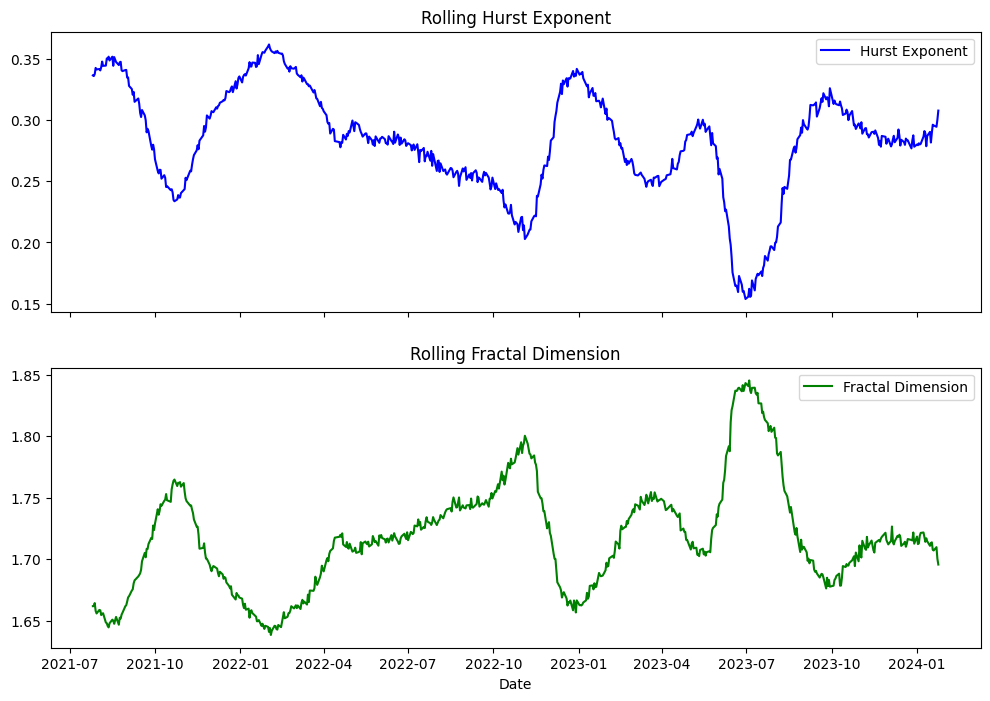

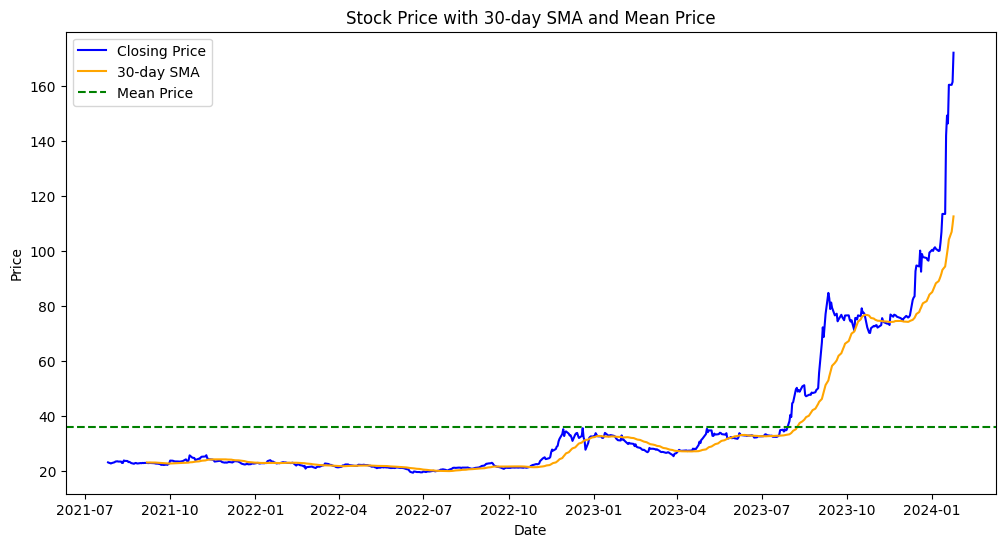

In [47]:
import matplotlib.pyplot as plt

# Plotting the Hurst Exponent and Fractal Dimension
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(df['hurst_exponent'], label='Hurst Exponent', color='blue')
ax1.set_title('Rolling Hurst Exponent')
ax1.legend()

ax2.plot(df['fractal_dimension'], label='Fractal Dimension', color='green')
ax2.set_title('Rolling Fractal Dimension')
ax2.set_xlabel('Date')
ax2.legend()

# Plotting the Closing Prices with 30-day SMA and Mean Price
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Closing Price', color='blue')
plt.plot(df['sma'], label='30-day SMA', color='orange')
plt.axhline(y=mean_price, linestyle='--', label='Mean Price', color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price with 30-day SMA and Mean Price')
plt.legend()

plt.show()


#### Understanding the Results:
Visualizing the stock price alongside its rolling Hurst Exponent and Fractal Dimension provides valuable insights:

- Rolling Hurst Exponent: A value close to 0.5 suggests a random walk (Brownian motion). Values below 0.5 indicate a series that tends to mean revert, while those above 0.5 signify a trending series.
- Rolling Fractal Dimension: A lower value suggests the series is more straightforward or “smooth”, while higher values point to increased complexity or “roughness”.